In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import subprocess
from tqdm.notebook import tqdm

# Plot multiple runs of single experiment

In [2]:
n_blocks = 2
n_threads_per_block = 1024
n_runs = 100
n_warmup = 10
n_padding = 1
n_floats = 1

In [25]:
res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_padding, n_floats]]], capture_output=True, text=True)

In [26]:
times_contiguous, times_block_malloc, times_all_malloc = [np.fromstring(x, sep=" ") for x in res.stdout.split("\n")[:2]]

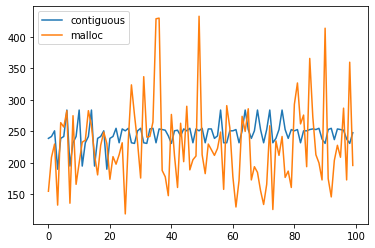

In [31]:
plt.plot(list(range(len(times_contiguous))), times_contiguous, label="contiguous")
plt.plot(list(range(len(times_malloc))), times_malloc, label="malloc")
plt.legend()
plt.show()

# Make plots

In [40]:
def get_mean_std(n_blocks, n_threads_per_block, n_floats, n_padding, n_runs=100, n_warmup=10):
    cmd_res = subprocess.run(["./a.out", *[str(x) for x in [n_blocks, n_threads_per_block, n_runs, n_warmup, n_padding, n_floats]]], capture_output=True, text=True)
    cmd_res.check_returncode()
    measurements = [np.fromstring(x, sep=" ") for x in cmd_res.stdout.split("\n")[:4]]
    res = []
    for m in measurements:
        res.append(np.mean(m))
        res.append(np.std(m))
  
    return res

## Compare methods by number of floats

  0%|          | 0/49 [00:00<?, ?it/s]

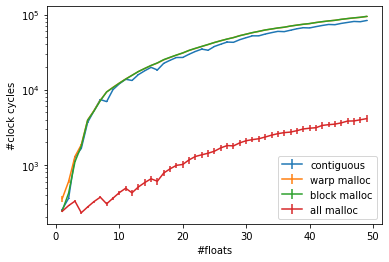

In [41]:
results = []
floats = list(range(1, 50))

n_blocks = 2
n_threads_per_block = 1024
n_padding = 0

for n_floats in tqdm(floats):
    results.append(get_mean_std(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block, n_floats=n_floats, n_padding=n_padding))


means_contig, stds_contig, means_warp_malloc, stds_warp_malloc, means_block_malloc, stds_block_malloc, means_all_malloc, stds_all_malloc = zip(*results)
    
plt.errorbar(floats, means_contig, stds_contig, label="contiguous")
plt.errorbar(floats, means_warp_malloc, stds_warp_malloc, label="warp malloc")
plt.errorbar(floats, means_block_malloc, stds_block_malloc, label="block malloc")
plt.errorbar(floats, means_all_malloc, stds_all_malloc, label="all malloc")
plt.legend()

plt.yscale("log")
plt.xlabel("#floats")
plt.ylabel("#clock cycles")
plt.show()

In [39]:
len(list(zip(*results)))

6

## Effect of stride

  0%|          | 0/50 [00:00<?, ?it/s]

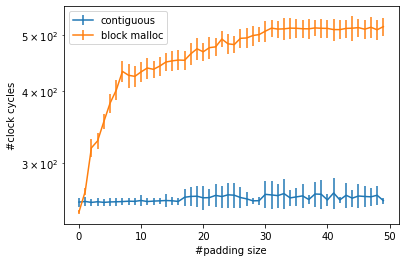

In [28]:
results = []
padding = list(range(50))

n_blocks = 2
n_threads_per_block = 1024
n_floats = 1

for n_padding in tqdm(padding):
    results.append(get_mean_std(n_blocks=n_blocks, n_threads_per_block=n_threads_per_block, n_floats=n_floats, n_padding=n_padding))


means_contig, stds_contig, means_block_malloc, stds_block_malloc, means_all_malloc, stds_all_malloc = zip(*results)
    
plt.errorbar(padding, means_contig, stds_contig, label="contiguous")
plt.errorbar(padding, means_block_malloc, stds_block_malloc, label="block malloc")

plt.legend()

plt.yscale("log")
plt.xlabel("#padding size")
plt.ylabel("#clock cycles")
plt.show()